In [5]:
import ast

In [8]:
code = '''a=b+1'''

**Cây AST**

In [12]:
tree = ast.parse(code)
ast.dump(tree,indent=4)

"Module(\n    body=[\n        Assign(\n            targets=[\n                Name(id='a', ctx=Store())],\n            value=BinOp(\n                left=Name(id='b', ctx=Load()),\n                op=Add(),\n                right=Constant(value=1)))],\n    type_ignores=[])"

**Token Sequence**

In [14]:
from transformers import AutoTokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokens = tokenizer.tokenize(code)
input_ids = tokenizer.encode(code)

print("Tokens:", tokens)
print("Input IDs:", input_ids)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokens: ['a', '=', 'b', '+', '1']
Input IDs: [101, 1037, 1027, 1038, 1009, 1015, 102]


**CFG**

In [16]:
import networkx as nx
import matplotlib.pyplot as plt


In [18]:
class CFGNode:
    def __init__(self, id, label):
        self.id = id
        self.label = label

class CFGBuilder(ast.NodeVisitor):
    def __init__(self):
        self.graph = nx.DiGraph()
        self.counter = 0
        self.last_node = None

    def add_node(self, label):
        node_id = self.counter
        self.graph.add_node(node_id, label=label)
        if self.last_node is not None:
            self.graph.add_edge(self.last_node, node_id)
        self.last_node = node_id
        self.counter += 1
        return node_id

    def visit_FunctionDef(self, node):
        self.add_node(f"Function: {node.name}")
        self.generic_visit(node)

    def visit_If(self, node):
        self.add_node(f"If: {ast.unparse(node.test)}")
        for stmt in node.body:
            self.visit(stmt)
        if node.orelse:
            for stmt in node.orelse:
                self.visit(stmt)

    def visit_While(self, node):
        self.add_node(f"While: {ast.unparse(node.test)}")
        for stmt in node.body:
            self.visit(stmt)

    def visit_For(self, node):
        self.add_node(f"For: {ast.unparse(node.target)} in {ast.unparse(node.iter)}")
        for stmt in node.body:
            self.visit(stmt)

    def visit_Expr(self, node):
        self.add_node(f"Expr: {ast.unparse(node)}")

    def visit_Assign(self, node):
        self.add_node(f"Assign: {ast.unparse(node)}")

def build_cfg(code):
    tree = ast.parse(code)
    builder = CFGBuilder()
    builder.visit(tree)
    return builder.graph

def print_adjacency_matrix(graph):
    adj_matrix = nx.to_numpy_array(graph, dtype=int)
    labels = nx.get_node_attributes(graph, 'label')

    print("Node Labels:")
    for node, label in labels.items():
        print(f"{node}: {label}")

    print("\nAdjacency Matrix:")
    print(adj_matrix)

# Sample code
code = '''
def example(x):
    if x > 0:
        y = 1
    else:
        y = -1
    return y
'''

cfg = build_cfg(code)
print_adjacency_matrix(cfg)


Node Labels:
0: Function: example
1: If: x > 0
2: Assign: y = 1
3: Assign: y = -1

Adjacency Matrix:
[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]


**DFG**

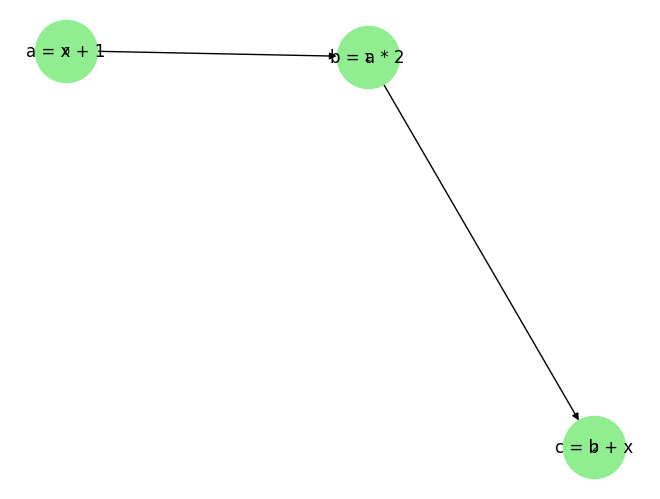

In [19]:
class DFGBuilder(ast.NodeVisitor):
    def __init__(self):
        self.graph = nx.DiGraph()
        self.current_defs = {}  # biến -> node
        self.counter = 0

    def add_node(self, label):
        node_id = self.counter
        self.graph.add_node(node_id, label=label)
        self.counter += 1
        return node_id

    def visit_Assign(self, node):
        # Lấy danh sách biến bên trái
        targets = [t.id for t in node.targets if isinstance(t, ast.Name)]
        # Lấy danh sách biến bên phải
        vars_used = [n.id for n in ast.walk(node.value) if isinstance(n, ast.Name)]

        # Tạo node mới
        label = f"{ast.unparse(node)}"
        node_id = self.add_node(label)

        # Thêm các cạnh từ biến phụ thuộc
        for var in vars_used:
            if var in self.current_defs:
                self.graph.add_edge(self.current_defs[var], node_id)

        # Ghi lại biến được gán ở node này
        for var in targets:
            self.current_defs[var] = node_id

    def visit_FunctionDef(self, node):
        self.generic_visit(node)

def build_dfg(code):
    tree = ast.parse(code)
    builder = DFGBuilder()
    builder.visit(tree)
    return builder.graph

def draw_dfg(graph):
    pos = nx.spring_layout(graph)
    labels = nx.get_node_attributes(graph, 'label')
    nx.draw(graph, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_size=8)
    nx.draw_networkx_labels(graph, pos, labels)
    plt.show()

# Code ví dụ
code = '''
def compute(x):
    a = x + 1
    b = a * 2
    c = b + x
    return c
'''

dfg = build_dfg(code)
draw_dfg(dfg)


**CPG**

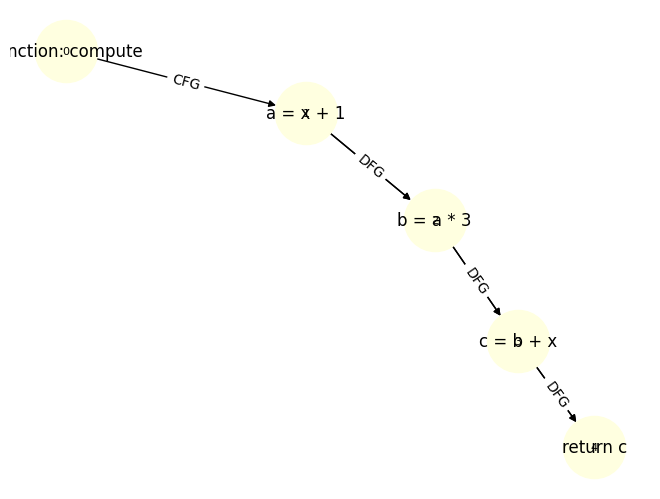

In [21]:
class CPGBuilder(ast.NodeVisitor):
    def __init__(self):
        self.graph = nx.MultiDiGraph()
        self.counter = 0
        self.last_node = None
        self.symbol_table = {}  # Biến -> node ID cuối cùng dùng nó

    def add_node(self, label, node_type):
        node_id = self.counter
        self.graph.add_node(node_id, label=label, type=node_type)
        self.counter += 1
        return node_id

    def add_edge(self, src, dst, edge_type):
        self.graph.add_edge(src, dst, type=edge_type)

    def visit_FunctionDef(self, node):
        func_node = self.add_node(f"Function: {node.name}", "FunctionDef")
        self.last_node = func_node
        for stmt in node.body:
            self.visit(stmt)

    def visit_Assign(self, node):
        label = ast.unparse(node)
        assign_node = self.add_node(label, "Assign")

        # CFG
        if self.last_node is not None:
            self.add_edge(self.last_node, assign_node, "CFG")

        # DFG
        vars_read = [n.id for n in ast.walk(node.value) if isinstance(n, ast.Name)]
        for var in vars_read:
            if var in self.symbol_table:
                self.add_edge(self.symbol_table[var], assign_node, "DFG")

        # Cập nhật biến gán
        for target in node.targets:
            if isinstance(target, ast.Name):
                self.symbol_table[target.id] = assign_node

        self.last_node = assign_node

    def visit_Return(self, node):
        label = ast.unparse(node)
        return_node = self.add_node(label, "Return")

        # CFG
        if self.last_node is not None:
            self.add_edge(self.last_node, return_node, "CFG")

        # DFG
        vars_read = [n.id for n in ast.walk(node.value) if isinstance(n, ast.Name)]
        for var in vars_read:
            if var in self.symbol_table:
                self.add_edge(self.symbol_table[var], return_node, "DFG")

        self.last_node = return_node

def build_cpg(code):
    tree = ast.parse(code)
    builder = CPGBuilder()
    builder.visit(tree)
    return builder.graph

def draw_cpg(graph):
    pos = nx.spring_layout(graph)
    labels = nx.get_node_attributes(graph, 'label')
    edge_labels = nx.get_edge_attributes(graph, 'type')

    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightyellow', font_size=8)
    nx.draw_networkx_labels(graph, pos, labels)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.show()

# Example Python code
code = '''
def compute(x):
    a = x + 1
    b = a * 3
    c = b + x
    return c
'''

cpg = build_cpg(code)
draw_cpg(cpg)


**Token Sequence mẫu**

In [22]:
import re
import ast
import tokenize
import io
from typing import List, Dict, Tuple, Optional
import numpy as np
from collections import Counter
import pickle

class CodeTokenizer:
    """
    Tokenizer cho mã nguồn Python - chuyển đổi code thành sequence của tokens
    Phù hợp với học phần Deep Learning for Software Engineering (CT487)
    """

    def __init__(self, vocab_size: int = 10000, pad_token: str = "<PAD>",
                 unk_token: str = "<UNK>", start_token: str = "<START>",
                 end_token: str = "<END>"):
        self.vocab_size = vocab_size
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.start_token = start_token
        self.end_token = end_token

        # Vocabulary mappings
        self.token_to_id = {}
        self.id_to_token = {}
        self.vocab_built = False

        # Special tokens
        self.special_tokens = [pad_token, unk_token, start_token, end_token]

    def extract_tokens_from_code(self, code: str) -> List[str]:
        """
        Trích xuất tokens từ mã nguồn Python sử dụng AST và tokenize
        """
        tokens = []

        try:
            # Method 1: Sử dụng Python tokenizer
            tokens_gen = tokenize.generate_tokens(io.StringIO(code).readline)
            for token in tokens_gen:
                if token.type not in [tokenize.NEWLINE, tokenize.NL,
                                    tokenize.INDENT, tokenize.DEDENT,
                                    tokenize.ENDMARKER, tokenize.COMMENT]:
                    if token.string.strip():
                        tokens.append(token.string.strip())
        except:
            # Method 2: Fallback - simple regex tokenization
            # Tách các từ khóa, operators, identifiers
            pattern = r'\b\w+\b|[+\-*/=<>!&|^~%]+|[(){}[\],;.:?]'
            tokens = re.findall(pattern, code)

        # Method 3: Thêm AST tokens cho cấu trúc syntax
        try:
            tree = ast.parse(code)
            ast_tokens = self._extract_ast_tokens(tree)
            tokens.extend(ast_tokens)
        except:
            pass

        return [token for token in tokens if token.strip()]

    def _extract_ast_tokens(self, node) -> List[str]:
        """
        Trích xuất structural tokens từ AST
        """
        tokens = []

        # Thêm tên node type như là token
        tokens.append(f"AST_{type(node).__name__}")

        # Đệ quy cho các node con
        for child in ast.iter_child_nodes(node):
            tokens.extend(self._extract_ast_tokens(child))

        return tokens

    def build_vocabulary(self, code_samples: List[str]) -> None:
        """
        Xây dựng vocabulary từ tập mã nguồn
        """
        print("Building vocabulary from code samples...")

        # Thu thập tất cả tokens
        all_tokens = []
        for code in code_samples:
            tokens = self.extract_tokens_from_code(code)
            all_tokens.extend(tokens)

        # Đếm tần suất
        token_counts = Counter(all_tokens)

        # Tạo vocabulary với special tokens trước
        self.token_to_id = {}
        self.id_to_token = {}

        # Thêm special tokens
        for i, token in enumerate(self.special_tokens):
            self.token_to_id[token] = i
            self.id_to_token[i] = token

        # Thêm các tokens phổ biến nhất
        most_common = token_counts.most_common(self.vocab_size - len(self.special_tokens))

        for i, (token, count) in enumerate(most_common):
            idx = i + len(self.special_tokens)
            self.token_to_id[token] = idx
            self.id_to_token[idx] = token

        self.vocab_built = True
        print(f"Vocabulary built with {len(self.token_to_id)} tokens")

    def tokenize_to_sequence(self, code: str, max_length: Optional[int] = None,
                           add_special_tokens: bool = True) -> List[int]:
        """
        Chuyển đổi code thành sequence of token IDs
        """
        if not self.vocab_built:
            raise ValueError("Vocabulary chưa được xây dựng. Hãy gọi build_vocabulary() trước.")

        # Trích xuất tokens
        tokens = self.extract_tokens_from_code(code)

        # Thêm special tokens
        if add_special_tokens:
            tokens = [self.start_token] + tokens + [self.end_token]

        # Chuyển đổi thành IDs
        token_ids = []
        for token in tokens:
            if token in self.token_to_id:
                token_ids.append(self.token_to_id[token])
            else:
                token_ids.append(self.token_to_id[self.unk_token])

        # Padding hoặc truncation
        if max_length:
            if len(token_ids) > max_length:
                token_ids = token_ids[:max_length]
            else:
                pad_id = self.token_to_id[self.pad_token]
                token_ids.extend([pad_id] * (max_length - len(token_ids)))

        return token_ids

    def decode_sequence(self, token_ids: List[int], remove_special_tokens: bool = True) -> str:
        """
        Chuyển đổi sequence of token IDs về code
        """
        tokens = []
        for token_id in token_ids:
            if token_id in self.id_to_token:
                token = self.id_to_token[token_id]
                if remove_special_tokens and token in self.special_tokens:
                    if token == self.pad_token:
                        break  # Stop at padding
                    continue
                tokens.append(token)

        return " ".join(tokens)

    def save_tokenizer(self, filepath: str) -> None:
        """
        Lưu tokenizer
        """
        tokenizer_data = {
            'token_to_id': self.token_to_id,
            'id_to_token': self.id_to_token,
            'vocab_size': self.vocab_size,
            'special_tokens': self.special_tokens,
            'vocab_built': self.vocab_built
        }

        with open(filepath, 'wb') as f:
            pickle.dump(tokenizer_data, f)
        print(f"Tokenizer saved to {filepath}")

    def load_tokenizer(self, filepath: str) -> None:
        """
        Load tokenizer
        """
        with open(filepath, 'rb') as f:
            tokenizer_data = pickle.load(f)

        self.token_to_id = tokenizer_data['token_to_id']
        self.id_to_token = tokenizer_data['id_to_token']
        self.vocab_size = tokenizer_data['vocab_size']
        self.special_tokens = tokenizer_data['special_tokens']
        self.vocab_built = tokenizer_data['vocab_built']

        print(f"Tokenizer loaded from {filepath}")

class CodeSequenceDataset:
    """
    Dataset class cho việc xử lý sequences của code
    Phù hợp với các bài toán: code completion, bug prediction, code generation
    """

    def __init__(self, tokenizer: CodeTokenizer):
        self.tokenizer = tokenizer
        self.sequences = []
        self.labels = []

    def add_code_sample(self, code: str, label: Optional[int] = None,
                       max_length: int = 512) -> None:
        """
        Thêm mẫu code vào dataset
        """
        sequence = self.tokenizer.tokenize_to_sequence(code, max_length=max_length)
        self.sequences.append(sequence)

        if label is not None:
            self.labels.append(label)

    def create_sliding_window_sequences(self, code: str, window_size: int = 50,
                                      stride: int = 25) -> List[List[int]]:
        """
        Tạo sliding window sequences cho code completion task
        """
        tokens = self.tokenizer.extract_tokens_from_code(code)
        token_ids = [self.tokenizer.token_to_id.get(token,
                    self.tokenizer.token_to_id[self.tokenizer.unk_token])
                    for token in tokens]

        sequences = []
        for i in range(0, len(token_ids) - window_size + 1, stride):
            window = token_ids[i:i + window_size]
            sequences.append(window)

        return sequences

    def get_sequences_and_labels(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Trả về sequences và labels dưới dạng numpy arrays
        """
        sequences = np.array(self.sequences)
        labels = np.array(self.labels) if self.labels else None
        return sequences, labels

# Utility functions cho các task cụ thể

def prepare_code_completion_data(codes: List[str], tokenizer: CodeTokenizer,
                               seq_length: int = 50) -> Tuple[np.ndarray, np.ndarray]:
    """
    Chuẩn bị dữ liệu cho code completion task
    Input: sequence của tokens
    Output: token tiếp theo
    """
    input_sequences = []
    target_sequences = []

    for code in codes:
        tokens = tokenizer.extract_tokens_from_code(code)
        token_ids = [tokenizer.token_to_id.get(token,
                    tokenizer.token_to_id[tokenizer.unk_token])
                    for token in tokens]

        # Tạo input-target pairs
        for i in range(len(token_ids) - seq_length):
            input_seq = token_ids[i:i + seq_length]
            target_token = token_ids[i + seq_length]

            input_sequences.append(input_seq)
            target_sequences.append(target_token)

    return np.array(input_sequences), np.array(target_sequences)

def prepare_bug_prediction_data(codes: List[str], bug_labels: List[int],
                              tokenizer: CodeTokenizer, max_length: int = 512) -> Tuple[np.ndarray, np.ndarray]:
    """
    Chuẩn bị dữ liệu cho bug prediction task
    Input: sequence của tokens từ code
    Output: label (0: không có bug, 1: có bug)
    """
    sequences = []
    labels = []

    for code, label in zip(codes, bug_labels):
        sequence = tokenizer.tokenize_to_sequence(code, max_length=max_length)
        sequences.append(sequence)
        labels.append(label)

    return np.array(sequences), np.array(labels)

# Example usage và demo
if __name__ == "__main__":
    # Sample code data
    sample_codes = [
        """
def calculate_sum(a, b):
    result = a + b
    return result
        """,
        """
class Rectangle:
    def __init__(self, width, height):
        self.width = width
        self.height = height

    def area(self):
        return self.width * self.height
        """,
        """
import numpy as np
def process_array(arr):
    if len(arr) == 0:
        return None
    return np.mean(arr)
        """,
        """
def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)
        """
    ]

    print("=== Demo: Code Tokenization for Deep Learning ===")
    print("Phù hợp với học phần CT487: Deep Learning for Software Engineering\n")

    # Tạo tokenizer
    tokenizer = CodeTokenizer(vocab_size=5000)

    # Xây dựng vocabulary
    tokenizer.build_vocabulary(sample_codes)

    # Demo tokenization
    test_code = """
def hello_world():
    print("Hello, World!")
    return True
    """

    print("Original code:")
    print(test_code)

    # Tokenize
    tokens = tokenizer.extract_tokens_from_code(test_code)
    print(f"\nExtracted tokens: {tokens}")

    # Convert to sequence
    sequence = tokenizer.tokenize_to_sequence(test_code, max_length=20)
    print(f"\nToken sequence (IDs): {sequence}")

    # Decode back
    decoded = tokenizer.decode_sequence(sequence)
    print(f"\nDecoded sequence: {decoded}")

    # Demo cho code completion
    print("\n=== Code Completion Data Preparation ===")
    input_seqs, target_tokens = prepare_code_completion_data(sample_codes, tokenizer, seq_length=10)
    print(f"Input sequences shape: {input_seqs.shape}")
    print(f"Target tokens shape: {target_tokens.shape}")
    print(f"Example input sequence: {input_seqs[0]}")
    print(f"Example target token: {target_tokens[0]}")

    # Demo cho bug prediction
    print("\n=== Bug Prediction Data Preparation ===")
    bug_labels = [0, 0, 1, 0]  # Example labels
    bug_sequences, bug_targets = prepare_bug_prediction_data(sample_codes, bug_labels, tokenizer)
    print(f"Bug prediction sequences shape: {bug_sequences.shape}")
    print(f"Bug prediction labels shape: {bug_targets.shape}")

    print("\n=== Vocabulary Statistics ===")
    print(f"Vocabulary size: {len(tokenizer.token_to_id)}")
    print(f"Most common tokens (first 10):")
    for i in range(min(10, len(tokenizer.id_to_token))):
        if i in tokenizer.id_to_token:
            print(f"  {i}: {tokenizer.id_to_token[i]}")

    # Save tokenizer
    tokenizer.save_tokenizer("code_tokenizer.pkl")

=== Demo: Code Tokenization for Deep Learning ===
Phù hợp với học phần CT487: Deep Learning for Software Engineering

Building vocabulary from code samples...
Vocabulary built with 66 tokens
Original code:

def hello_world():
    print("Hello, World!")
    return True
    

Extracted tokens: ['def', 'hello_world', '(', ')', ':', 'print', '(', '"Hello, World!"', ')', 'return', 'True', 'AST_Module', 'AST_FunctionDef', 'AST_arguments', 'AST_Expr', 'AST_Call', 'AST_Name', 'AST_Load', 'AST_Constant', 'AST_Return', 'AST_Constant']

Token sequence (IDs): [2, 13, 1, 6, 7, 8, 1, 6, 1, 7, 10, 1, 21, 14, 15, 1, 24, 5, 4, 19]

Decoded sequence: def ( ) : ( ) return AST_Module AST_FunctionDef AST_arguments AST_Call AST_Name AST_Load AST_Constant

=== Code Completion Data Preparation ===
Input sequences shape: (175, 10)
Target tokens shape: (175,)
Example input sequence: [13 43  6 31 25 32  7  8 33 26]
Example target token: 31

=== Bug Prediction Data Preparation ===
Bug prediction sequences shape: 